# Random walks $R_t$ factor with Gamma-Poisson likelihood

In [1]:
from datetime import date
import locale

import pandas as pd
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import theano.tensor as tt

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [10, 5], 'figure.dpi': 95})

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/treker-mk/data/master/csv/stats.csv')
data = data.assign(date = pd.to_datetime(data.date))
data = data[data.day >= 0]
data.tail(5)[['date', 'cases.confirmed']]

,date,cases.confirmed
190,2020-09-01,145.0
191,2020-09-02,166.0
192,2020-09-03,109.0
193,2020-09-04,127.0
194,2020-09-05,92.0


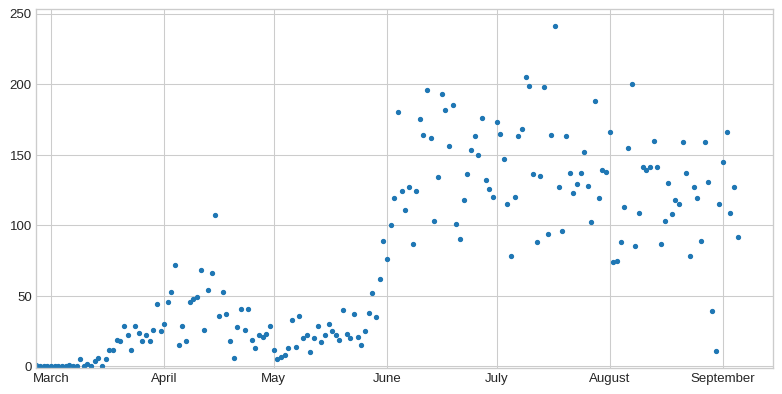

In [4]:
plt.scatter(data.date, data['cases.confirmed'], marker='.')
plt.gca().set(ylim=(-1, None), xlim=(data.date.min(), None))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

### Model

We model the new daily cases as simple reproduction with a Gamma-Poisson likelihood (aka. Negative Binomial):

$$ \text{observed}_t \sim \text{NB}(\mu_t, \alpha) $$

where the daily average is simply a multiple of the day before:

$$ \mu_{t+1} = R_t  \mu_t $$

which can be rewriten as (note: $\mu_0 = 1$):

$$ \log \mu_{t+1} = \log \mu_{t} + \log R_t $$

$$ \log \mu_t = \sum_{\tau=1}^t \log R_{\tau} $$

We will model the $R_t$ as Gaussian random walk prior in the log scale (the factor is always positive):

$$ \log R_{t+1} \sim \mathcal{N}(\log R_t, \sigma^2) $$

and a regularizing hyperprior for $\sigma$:

$$ \sigma \sim \text{Exponential}(1/0.2) $$

Finally, for the dispersion parameter we will use Cauchy prior:

$$ \alpha \sim \text{HalfCauchy}(10) $$

In [5]:
with pm.Model() as model4:
    N = data.shape[0]

    sigma = pm.Exponential('sigma', 1/0.1)
    logR = pm.GaussianRandomWalk(
        'logR',
        init=pm.Normal.dist(0, 1),
        sigma=sigma,
        shape=N)

    R = pm.Deterministic('R', tt.exp(logR))
    mu = pm.Deterministic('mu', tt.exp(tt.cumsum(logR)))

    _alpha = pm.HalfCauchy('_alpha', 1)
    alpha = _alpha * 10
    pm.NegativeBinomial(
        'obs', mu=mu, alpha=alpha,
        observed=data['cases.confirmed'].values)

    trace4 = pm.sample(15000, tune=25000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [_alpha, logR, sigma]


Sampling 2 chains for 25_000 tune and 15_000 draw iterations (50_000 + 30_000 draws total) took 417 seconds.
The number of effective samples is smaller than 10% for some parameters.


/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


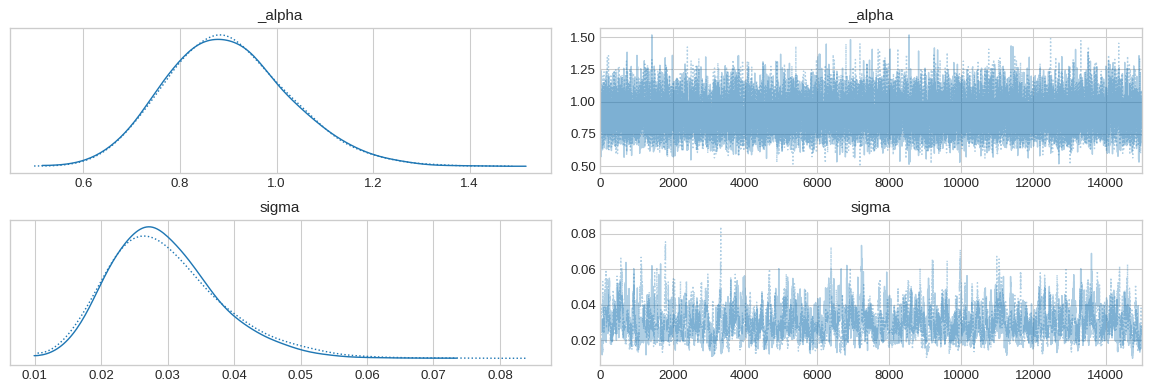

In [6]:
pm.traceplot(trace4, var_names=['_alpha', 'sigma'])
None

In [7]:
pm.summary(trace4, var_names=['_alpha', 'sigma'])

/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
_alpha,0.902,0.128,0.670,1.145,0.001,0.001,15853.0,15853.0,15755.0,19142.0,1.0
sigma,0.030,0.008,0.015,0.045,0.000,0.000,689.0,689.0,663.0,1273.0,1.0


/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:338: U

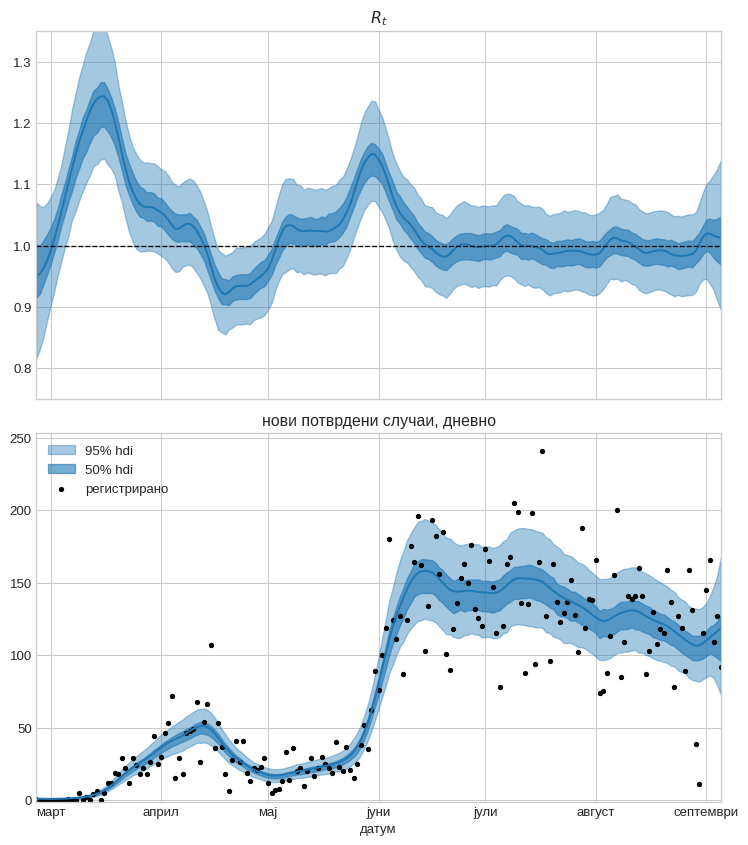

In [8]:
locale.setlocale(6, 'mk_MK.UTF-8')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True)
tmp = pm.hpd(trace4['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trace4['R'].mean(axis=0))
tmp.mean_.plot(ax=ax1)
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, color='C0')

tmp = pm.hpd(trace4['R'] , hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data['date'])
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, color='C0')


ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R_t$', xlabel='датум', ylim=(0.75, 1.35), xlim=(data.date.min(), None))


tmp = pm.hpd(trace4['mu'], hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trace4['mu'].mean(axis=0))
tmp.mean_.plot(label='')
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='95% hdi', color='C0')

tmp = pm.hpd(trace4['mu'], hdi_prob=0.50)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, label='50% hdi', color='C0')

ax2.scatter(tmp.index, data['cases.confirmed'], color='k', label='регистрирано', marker='.')
ax2.set(title='нови потврдени случаи, дневно', xlabel='датум', ylim=(-1, None))

ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

fig.tight_layout()
fig.savefig('mk_daily_R.png')
None

/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/petrushev/etc/jupenv/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


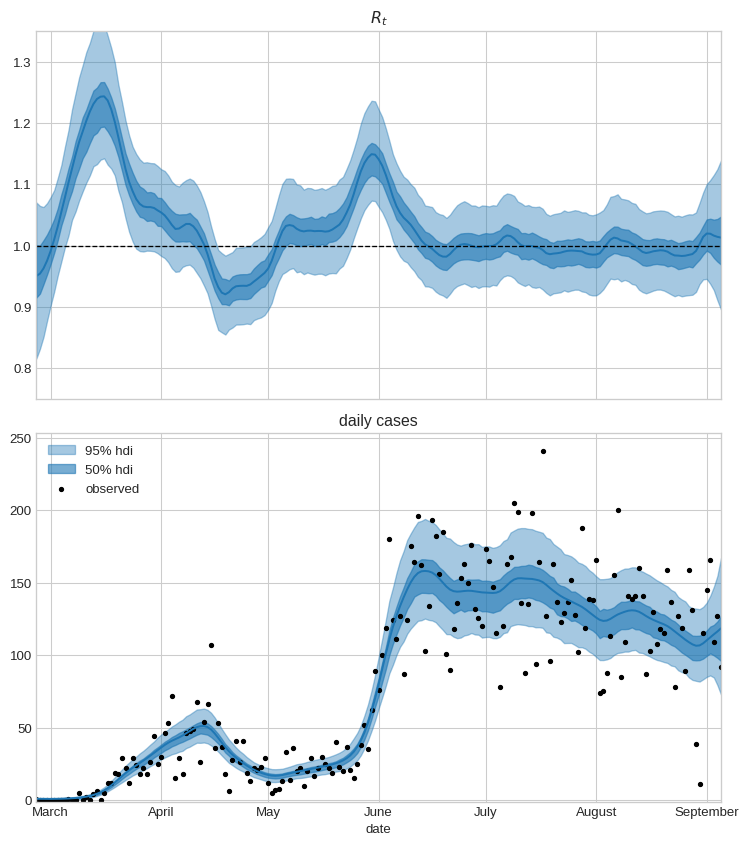

In [9]:
locale.setlocale(6, 'en_US.UTF-8')
f'{date.today():%B}'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9), sharex=True)
tmp = pm.hpd(trace4['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trace4['R'].mean(axis=0))
tmp.mean_.plot(ax=ax1)
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, color='C0')

tmp = pm.hpd(trace4['R'] , hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data['date'])
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, color='C0')


ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R_t$', xlabel='date', ylim=(0.75, 1.35), xlim=(data.date.min(), None))


tmp = pm.hpd(trace4['mu'], hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data['date'])
tmp = tmp.assign(mean_ = trace4['mu'].mean(axis=0))
tmp.mean_.plot(label='')
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.4, label='95% hdi', color='C0')

tmp = pm.hpd(trace4['mu'], hdi_prob=0.50)
tmp = pd.DataFrame(tmp, index=data['date'])
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.6, label='50% hdi', color='C0')

ax2.scatter(tmp.index, data['cases.confirmed'], color='k', label='observed', marker='.')
ax2.set(title='daily cases', xlabel='date', ylim=(-1, None))

ax2.legend(loc='upper left')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%B'))

fig.tight_layout()
fig.savefig('mk_daily_R_en.png')
None

In [10]:
print(f"P(R > 1) = {(((trace4['R'][:, -1] > 1).mean(axis=0) * 100)):.1f}%")

P(R > 1) = 57.6%


In [11]:
print(f"P(R* > R) = {(trace4['R'][:, -1] > trace4['R'][:, -2]).mean(axis=0) * 100:.1f}%")

P(R* > R) = 47.9%
